In [51]:
import torchvision
import torch
from torch import Tensor
from plots import plot_training_result, plot_image_data
from torch.utils.data import ConcatDataset

from vae.mnist_vae import VaeAutoencoderClassifier
from image_classifier.image_classifier import MNISTClassifier
from utils import fid

In [2]:
training_data = torchvision.datasets.MNIST(root='../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

print(training_data)
print(testing_data)

input = training_data.data[:60000] / 255.0
labels = training_data.targets[:60000]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST_train
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/MNIST_test
    Split: Test
    StandardTransform
Transform: ToTensor()


In [26]:
# Train VAE
vae = VaeAutoencoderClassifier(dim_encoding=2)

merged_dataset = ConcatDataset([training_data, testing_data])

# alpha value of 5000 and 20 epochs seems to be the best
# increasing alpha will decrease KL divergence loss but worse generated data
vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li, kl_loss_li = vae.train_model(
    merged_dataset,
    batch_size=100,
    alpha=5000.0,
    epochs=20
)

Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10
Finished epoch:  11
Finished epoch:  12
Finished epoch:  13
Finished epoch:  14
Finished epoch:  15
Finished epoch:  16
Finished epoch:  17
Finished epoch:  18
Finished epoch:  19
Finished epoch:  20


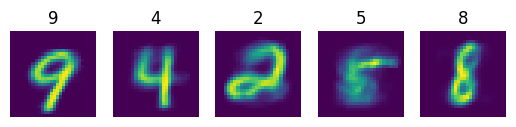

In [31]:
# plot generated data
image_tensor, label_tensor = vae.generate_data(n_samples=5)
plot_image_data(image_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

In [32]:
# move tensors to cpu before converting to np array
np_classifier_accuracy_li = []
np_classifier_loss_li = []
np_vae_loss_li = []
np_kl_loss_li = []

for output in classifier_accuracy_li:
    if isinstance(output, Tensor):
        np_classifier_accuracy_li.append(output.cpu().detach().numpy())

for output in classifier_loss_li:
    if isinstance(output, Tensor):
        np_classifier_loss_li.append(output.cpu().detach().numpy())
        
for output in vae_loss_li:
    if isinstance(output, Tensor):
        np_vae_loss_li.append(output.cpu().detach().numpy())

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())


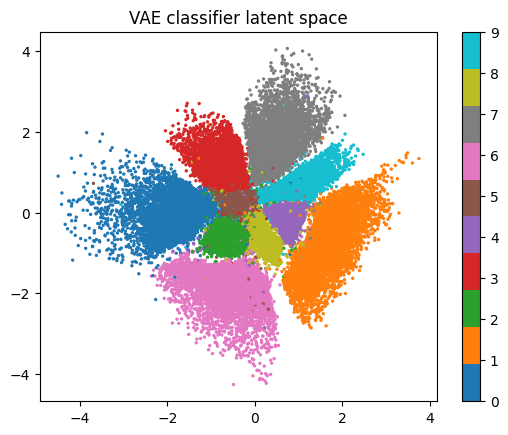

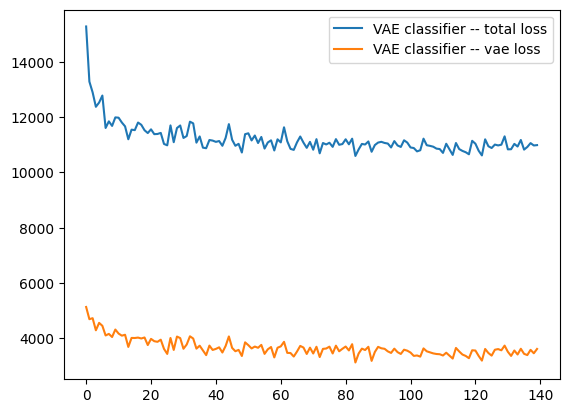

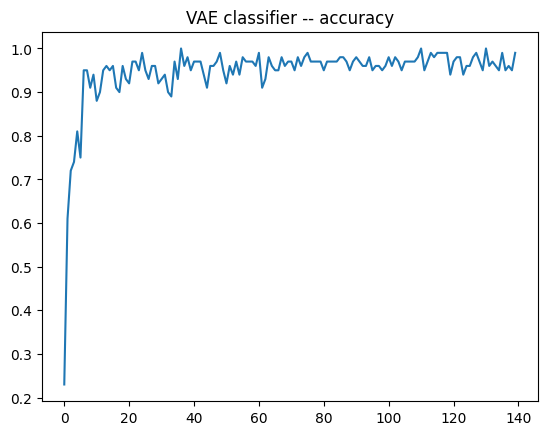

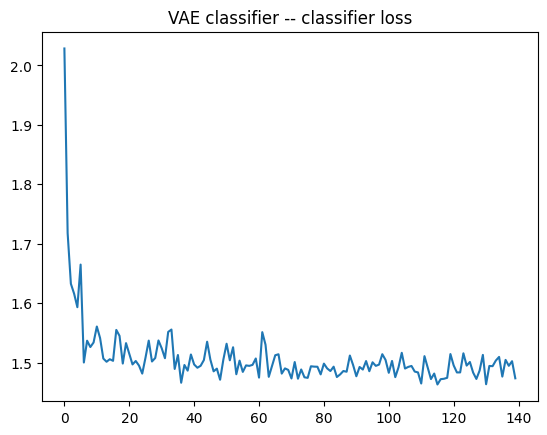

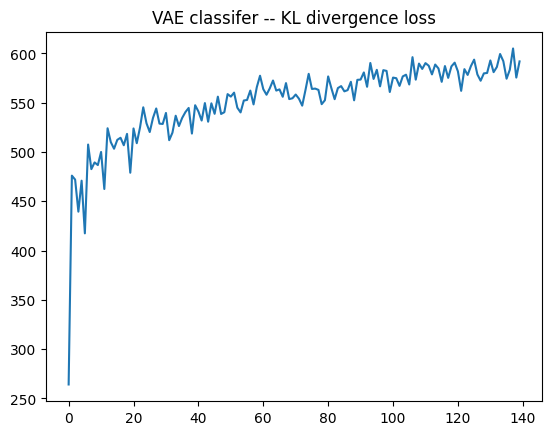

In [33]:
# plot results
plot_training_result(
    input=input,
    labels=labels,
    vae_model_classifier=vae_classifier_model,
    vae_loss_li=np_vae_loss_li,
    total_losses=total_losses, 
    classifier_accuracy_li=np_classifier_accuracy_li, 
    classifier_loss_li=np_classifier_loss_li,
    kl_loss_li=np_kl_loss_li
)

In [34]:
# train classifier for performance evaluation

classifier = MNISTClassifier(input_size=784, num_classes=10)
classifier.train_model(training_data, batch_size=100, epochs=5)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

Epoch done:  1
Epoch done:  2
Epoch done:  3
Epoch done:  4
Epoch done:  5
Test accuracy:  0.9722


In [39]:
x, y = vae.generate_data(n_samples=1)

for i in range(100):
    image_tensor, label_tensor = vae.generate_data(n_samples=100)
    x = torch.cat((x, image_tensor), dim=0)
    y = torch.cat((y, label_tensor), dim=0)

assert x.shape[0] == y.shape[0]
print("Number of images: ", x.shape[0])

Number of images:  10001


In [58]:
# test quality of images
accuracy = classifier.test_model_syn_img(x, y)
print("Accuracy: ", accuracy)



Accuracy:  0.9522047795220479


ValueError: Expected 4D tensor as input. But input has 5 dimenstions.